In [55]:
# Adapted from @statsguyphd Twitter thread:
# https://twitter.com/statsguyphd/status/1324352879768076294

import requests
from bs4 import BeautifulSoup as bs
from scipy.stats import chisquare
from math import log10
import numpy as np

def getsource(url='https://county.milwaukee.gov/EN/County-Clerk/Off-Nav/Election-Results/Election-Results-Fall-2020'):
    headers = {'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_3) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/35.0.1916.47 Safari/537.36'}
    r = requests.get(url, headers=headers)
    data = r.text
    soup=bs(data,'html.parser')
    return soup

def getBenfords():
    expected = [log10(1 + 1./d) for d in range(1, 10)]
    return expected

def chiTest(actual, expected):
    return chisquare(f_obs=actual, f_exp=expected)

def calcfreqs(inlist, num):
    inlist[num-1] += 1
    return inlist

benfords_exp = getBenfords()

dataDict = {'Num': [], 'Ward': []}
digit_counts = {}
candidates = ['Biden', 'Trump', 'Blankenship', 'Jorgensen', 'Carroll', 'Writein']
for candidate in candidates:
    dataDict[candidate] = []
    digit_counts[candidate] = [0]*9
entries = ['Num', 'Ward']
entries.extend(candidates)

In [14]:
# Load and Parse Data
source = getsource()
datalist = source.findAll('table', {'class': 'precinctTable'})
federal_table = datalist[1]

In [56]:
# Count leading digit frequencies for each candidate
vals = datalist[1].findAll('td')
row_width = 2+len(candidates)
vals_past_header = vals[row_width:]
for i, val in enumerate(vals_past_header):
    col = i % row_width
    if col == 0:
        dataDict['Num'].append(val.text)
    elif col == 1:
        dataDict['Ward'].append(val.text)
    else:
        dataDict[entries[col]].append(val.text)
        digit = int(val.text[0])
        digit_idx = digit - 1
        digit_counts[entries[col]][digit_idx] += 1

In [57]:
expected = {
    candidate: [sum(digit_counts[candidate])*a for a in benfords_exp]
    for candidate in candidates
}
test_vals = {}
test_vals['chi'] = {candidate: chiTest(digit_counts[candidate], expected[candidate])[0]
           for candidate in candidates
          }
test_vals['chi_p'] = {candidate: chiTest(digit_counts[candidate], expected[candidate])[1]
           for candidate in candidates
          }

{'Biden': 145.32657299471006, 'Trump': 26.598421385294834, 'Blankenship': 971.966060605043, 'Jorgensen': 32.04781298508081, 'Carroll': 688.9723968798929, 'Writein': 104.2471065226605}
{'Biden': 1.8474805363266137e-27, 'Trump': 0.0008291433194097523, 'Blankenship': 1.6774414693577976e-204, 'Jorgensen': 9.132274435832121e-05, 'Carroll': 1.6931550101314024e-143, 'Writein': 5.770397759664128e-19}


In [63]:
print("Digit Counts:")
for candidate, digits in digit_counts.items():
    print(candidate, digits)
print("="*10)
print("Chi Test Statistics:")
for candidate, chi in test_vals['chi'].items():
    print(candidate, chi)
print("="*10)
print("Chi P-Vals:")
for candidate, chi_p in test_vals['chi_p'].items():
    print(candidate, chi_p)

Digit Counts:
Biden [86, 35, 52, 69, 79, 62, 42, 28, 26]
Trump [115, 85, 89, 57, 35, 36, 27, 16, 19]
Blankenship [154, 85, 48, 17, 8, 5, 1, 2, 159]
Jorgensen [169, 77, 56, 40, 31, 19, 24, 21, 42]
Carroll [128, 109, 63, 21, 13, 6, 4, 0, 135]
Writein [115, 83, 64, 56, 31, 27, 23, 14, 66]
Chi Test Statistics:
Biden 145.32657299471006
Trump 26.598421385294834
Blankenship 971.966060605043
Jorgensen 32.04781298508081
Carroll 688.9723968798929
Writein 104.2471065226605
Chi P-Vals:
Biden 1.8474805363266137e-27
Trump 0.0008291433194097523
Blankenship 1.6774414693577976e-204
Jorgensen 9.132274435832121e-05
Carroll 1.6931550101314024e-143
Writein 5.770397759664128e-19


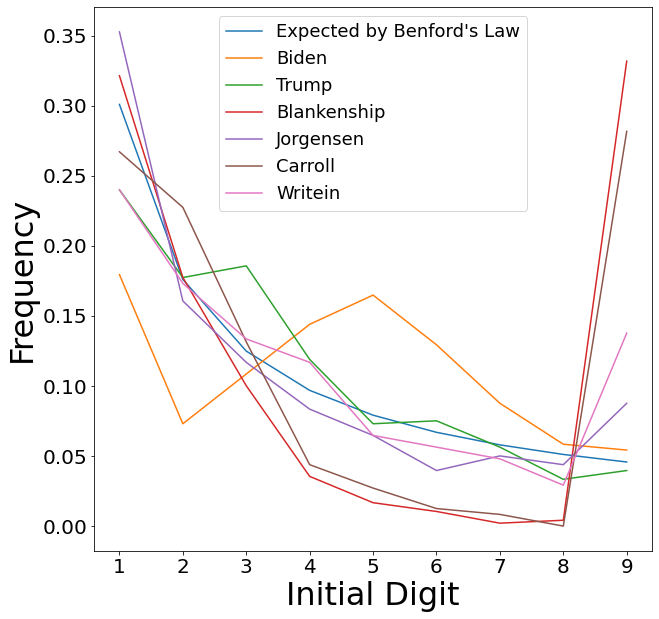

In [64]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(10, 10))
plt.plot(range(1, 10), benfords_exp, label="Expected by Benford's Law")
for candidate, counts in digit_counts.items():
    plt.plot(range(1, 10), counts / np.sum(counts), label=candidate)
plt.legend(fontsize=18)
plt.xlabel("Initial Digit", fontsize=32)
plt.ylabel("Frequency", fontsize=32)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()